Generating solar system visualizations starting from November 17, 2025
Loading astronomical data...
Creating visualization for Today...


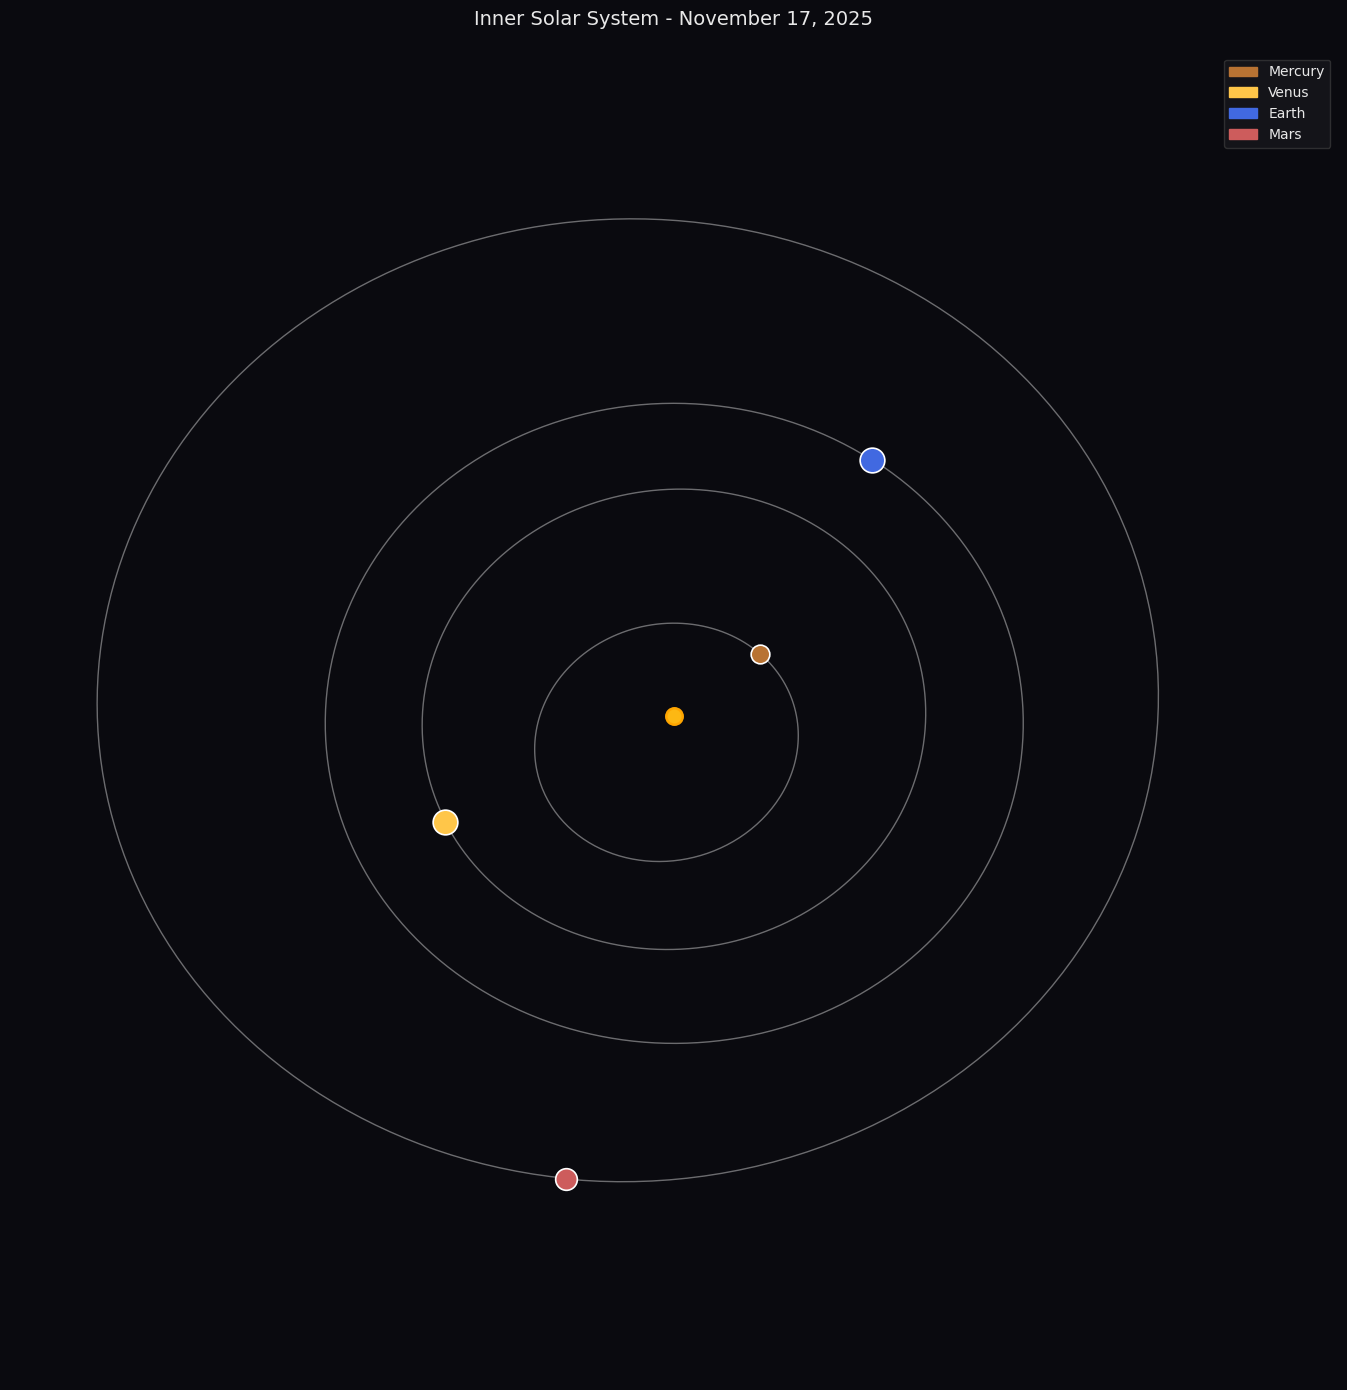

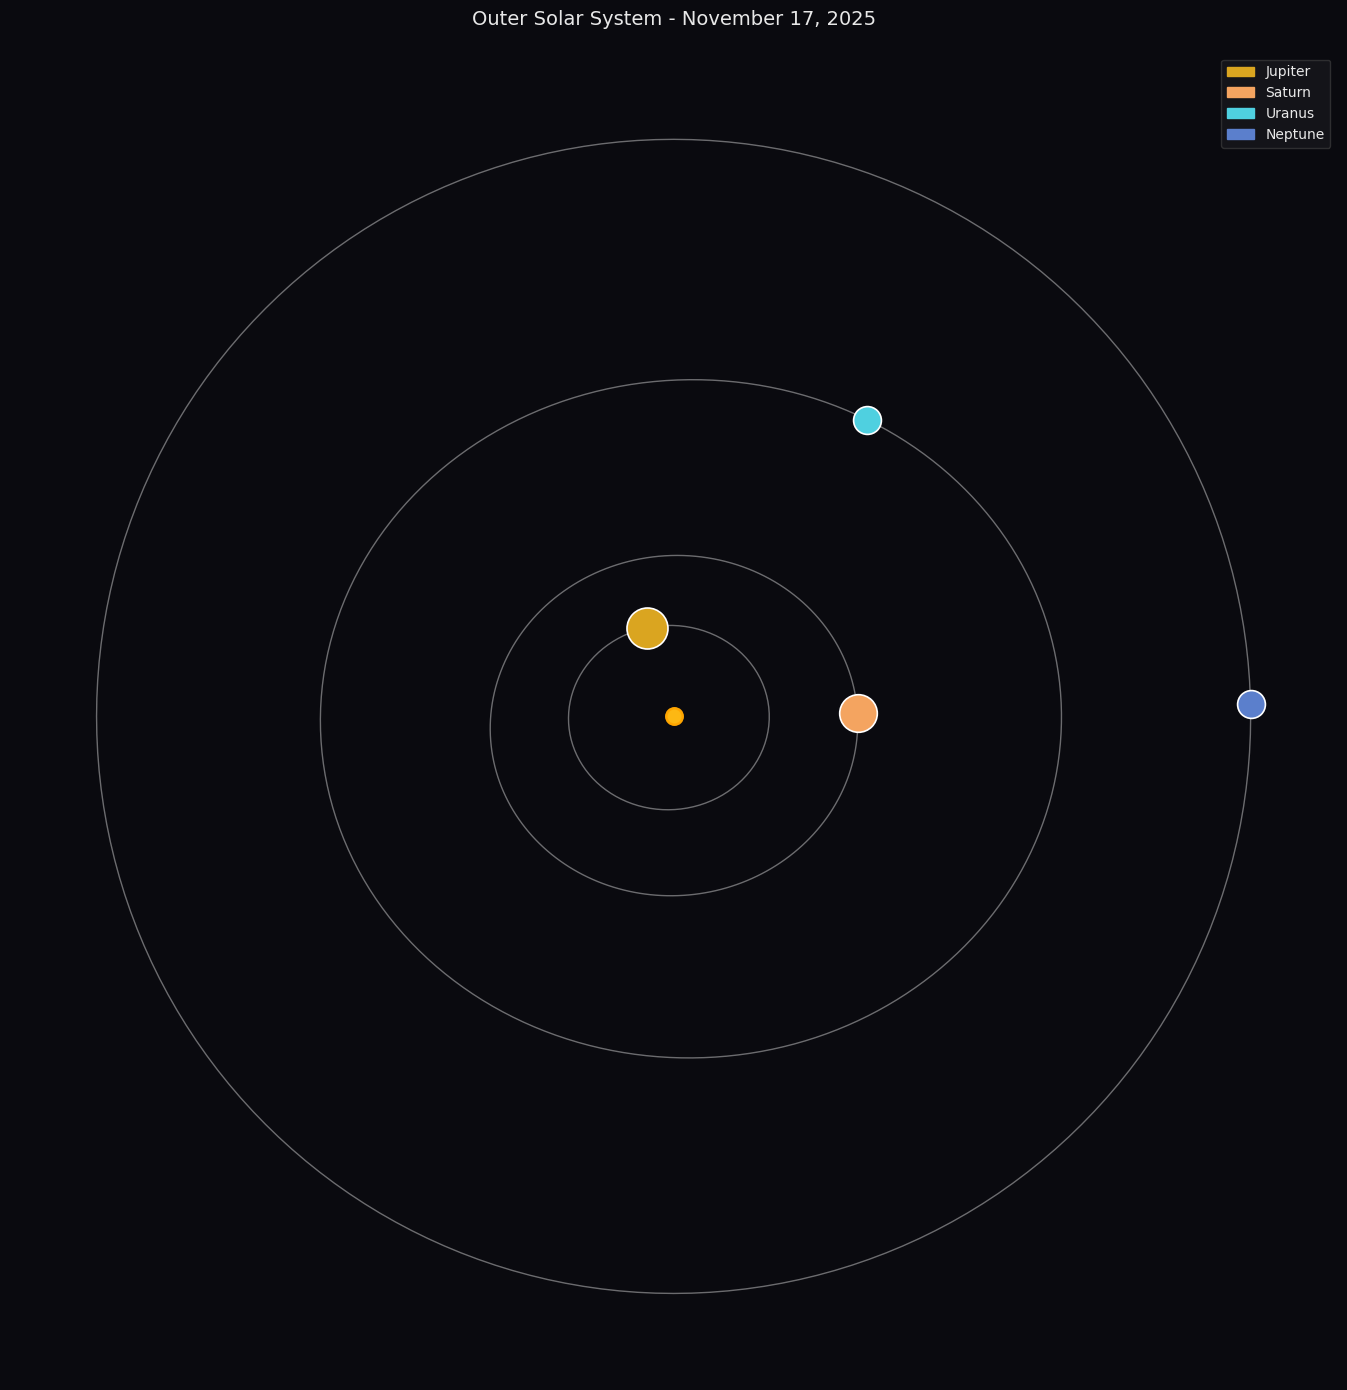

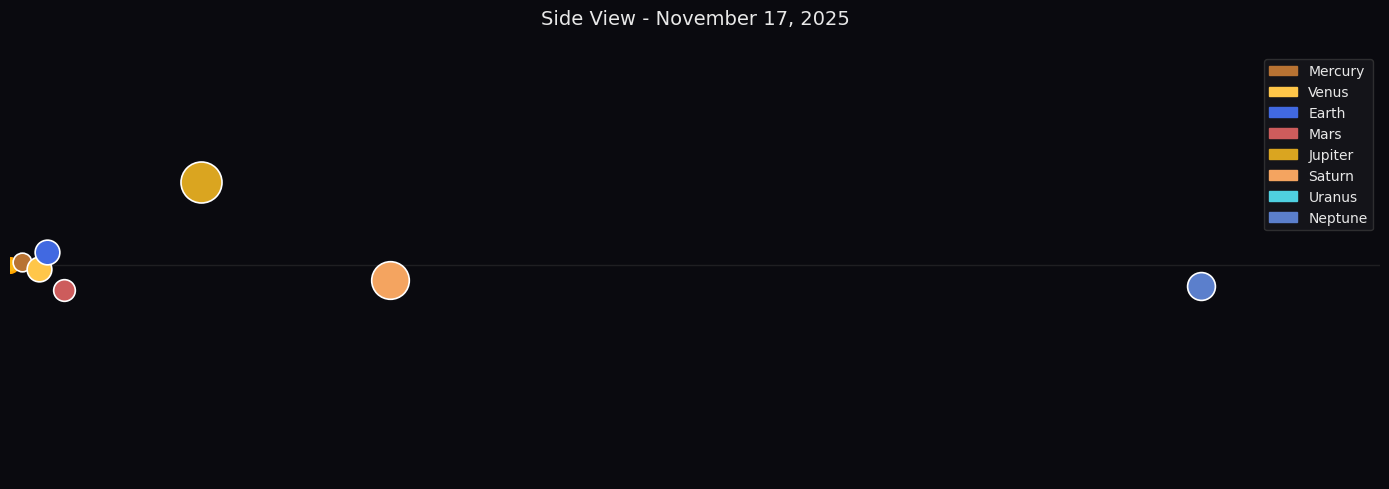

All visualizations complete!


In [21]:
# Updated code with background stars removed and more accurate planet orbits

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.patches import Circle
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')

from skyfield.api import load, wgs84, Star
from skyfield.data import hipparcos

# Visual properties for celestial bodies - distinct colors
body_properties = {
    'mercury': {'color': '#B87333', 'size': 8, 'name': 'Mercury'},
    'venus': {'color': '#FFC649', 'size': 10, 'name': 'Venus'},
    'earth': {'color': '#4169E1', 'size': 10, 'name': 'Earth'},
    'mars': {'color': '#CD5C5C', 'size': 9, 'name': 'Mars'},
    'jupiter': {'color': '#DAA520', 'size': 15, 'name': 'Jupiter'},
    'saturn': {'color': '#F4A460', 'size': 14, 'name': 'Saturn'},
    'uranus': {'color': '#4FD0E0', 'size': 11, 'name': 'Uranus'},
    'neptune': {'color': '#5B7FCC', 'size': 11, 'name': 'Neptune'},
}

# REMOVED star functions entirely

def get_positions(date):
    """Get positions of all bodies for a given date using Skyfield, with accurate orbit curves."""

    eph = load('de440s.bsp')
    ts = load.timescale()
    from skyfield.api import utc

    date_utc = date.replace(tzinfo=utc)
    t = ts.from_datetime(date_utc)

    positions = {}
    orbits = {}

    planet_names = ['mercury', 'venus', 'earth', 'mars',
                    'jupiter', 'saturn', 'uranus', 'neptune']

    for planet_name in planet_names:
        try:
            planet = eph[f'{planet_name} barycenter']
            pos = planet.at(t).position.au
            positions[planet_name] = {'x': pos[0], 'y': pos[1], 'z': pos[2]}

            # Instead of using average orbital period, sample the planet path directly
            num_points = 200
            orbit_points = []  # full orbit (Neptune handled specially)

            # Generate orbit positions safely for all planets
            for i in range(num_points + 1):
                orbital_periods = {
                    'mercury': 88,
                    'venus': 225,
                    'earth': 365,
                    'mars': 687,
                    'jupiter': 4333,
                    'saturn': 10759,
                    'uranus': 30687,
                    'neptune': 60190,
                }

                period = orbital_periods.get(planet_name, 365)

                # Sample within ephemeris-safe range (~±100 years)
                safe_days = 365 * 100

                if planet_name == 'neptune':
                    # Sample ±100 years (200*365 days) but wrap into circle
                    theta = (i / num_points) * 2 * np.pi
                    # radius from current position
                    r = np.sqrt(pos[0]**2 + pos[1]**2)
                    x = r * np.cos(theta)
                    y = r * np.sin(theta)
                    orbit_points.append((x, y, 0.0))
                else:
                    # Safe ephemeris sampling for other planets
                    days_offset = (i / num_points) * min(period, safe_days)
                    t_orbit = ts.from_datetime((date + timedelta(days=days_offset)).replace(tzinfo=utc))
                    orbit_pos = planet.at(t_orbit).position.au
                    orbit_points.append((orbit_pos[0], orbit_pos[1], orbit_pos[2]))

            orbits[planet_name] = orbit_points

        except:
            pass

    return positions, orbits


def plot_solar_system(date, planet_filter=None):
    positions, orbits = get_positions(date)

    if planet_filter == 'inner':
        planets_to_plot = ['mercury', 'venus', 'earth', 'mars']
        title_prefix = "Inner Solar System - "
    elif planet_filter == 'outer':
        planets_to_plot = ['jupiter', 'saturn', 'uranus', 'neptune']
        title_prefix = "Outer Solar System - "
    else:
        planets_to_plot = list(body_properties.keys())
        title_prefix = ""

    fig, ax = plt.subplots(figsize=(14, 14))
    fig.patch.set_facecolor('#0a0a0f')
    ax.set_facecolor('#0a0a0f')

    max_dist = 0
    for body_name in planets_to_plot:
        if body_name in orbits:
            orbit_path = np.array(orbits[body_name])
            ax.plot(orbit_path[:, 0], orbit_path[:, 1],
                    color='white', alpha=0.4, linewidth=1.0, zorder=20)
            r = np.sqrt(orbit_path[:, 0]**2 + orbit_path[:, 1]**2)
            max_dist = max(max_dist, r.max())

    # Sun
    ax.scatter(0, 0, c='#FDB813', s=140, zorder=100,
               edgecolors='#FFA500', linewidths=1.8, alpha=1)

    legend_elements = []
    for body_name in planets_to_plot:
        if body_name in positions and body_name in body_properties:
            pos_data = positions[body_name]
            props = body_properties[body_name]
            x, y, z = pos_data['x'], pos_data['y'], pos_data['z']

            r = np.sqrt(x**2 + y**2)
            max_dist = max(max_dist, r)

            ax.scatter(x, y, c=props['color'], s=props['size']**2.5,
                       zorder=100, edgecolors='white', linewidths=1.2, alpha=1)
            legend_elements.append(mpatches.Patch(color=props['color'], label=props['name']))

    limit = max_dist * 1.15
    ax.set_xlim(-limit, limit)
    ax.set_ylim(-limit, limit)
    ax.set_title(f"{title_prefix}{date.strftime('%B %d, %Y')}",
                 color='#E8E8E8', fontsize=14, pad=20)

    ax.grid(True, alpha=0.08, color='#404040', linewidth=0.5, linestyle=':')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    legend = ax.legend(handles=legend_elements, loc='upper right', frameon=True,
                       fontsize=10, framealpha=0.65, edgecolor='#404040',
                       facecolor='#1a1a1f')
    plt.setp(legend.get_texts(), color='#E8E8E8')

    ax.set_aspect('equal')
    plt.tight_layout()
    return fig


def plot_side_view(date):
    positions, orbits = get_positions(date)

    fig, ax = plt.subplots(figsize=(14, 5))
    fig.patch.set_facecolor('#0a0a0f')
    ax.set_facecolor('#0a0a0f')

    # Sun
    ax.scatter(0, 0, c='#FDB813', s=110, zorder=100,
               edgecolors='#FFA500', linewidths=1.8, alpha=1)

    max_dist = 0
    legend_elements = []

    for body_name, pos_data in positions.items():
        if body_name in body_properties:
            props = body_properties[body_name]
            x, y, z = pos_data['x'], pos_data['y'], pos_data['z']
            r_xy = np.sqrt(x**2 + y**2)
            max_dist = max(max_dist, r_xy)

            ax.scatter(r_xy, z, c=props['color'], s=props['size']**2.5,
                       zorder=100, edgecolors='white', linewidths=1.2, alpha=1)
            legend_elements.append(mpatches.Patch(color=props['color'], label=props['name']))

    limit = max_dist * 1.15
    ax.set_xlim(0, limit)
    ax.set_ylim(-limit * 0.15, limit * 0.15)

    ax.set_title(f'Side View - {date.strftime("%B %d, %Y")}',
                 color='#E8E8E8', fontsize=14, pad=20)

    ax.grid(True, alpha=0.08, color='#404040', linewidth=0.5, linestyle=':')
    ax.axhline(y=0, color='#404040', linewidth=1, alpha=0.4)

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])

    legend = ax.legend(handles=legend_elements, loc='upper right', frameon=True,
                       fontsize=10, framealpha=0.65, edgecolor='#404040',
                       facecolor='#1a1a1f')
    plt.setp(legend.get_texts(), color='#E8E8E8')

    plt.tight_layout()
    return fig

# Main execution block
if __name__ == "__main__":
    base_date = datetime.now()
    time_periods = [(base_date, "Today")]

    print(f"Generating solar system visualizations starting from {base_date.strftime('%B %d, %Y')}")
    print("Loading astronomical data...")

    for date, label in time_periods:
        print(f"Creating visualization for {label}...")

        fig_inner = plot_solar_system(date, planet_filter='inner')
        plt.savefig(f'solar_system_inner_{label.lower().replace(" ", "_")}.png',
                    dpi=200, facecolor='#0a0a0f', bbox_inches='tight')
        plt.show(); plt.close()

        fig_outer = plot_solar_system(date, planet_filter='outer')
        plt.savefig(f'solar_system_outer_{label.lower().replace(" ", "_")}.png',
                    dpi=200, facecolor='#0a0a0f', bbox_inches='tight')
        plt.show(); plt.close()

        fig_side = plot_side_view(date)
        plt.savefig(f'solar_system_side_{label.lower().replace(" ", "_")}.png',
                    dpi=200, facecolor='#0a0a0f', bbox_inches='tight')
        plt.show(); plt.close()

    print("All visualizations complete!")
